In [1]:
import sys; sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from simulator import ContextualWebServer, BanditSimulator
from policy import LinUCB, LogisticThompsonSampling, LinThompsonSampling
from ope_estimator import NNTrainer, InversePropensityScore as IPS

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_action=30
dim_user_context=10
dim_context=10
reward_type="binary"
noise_ver=1.

In [3]:
# web server
web_server = ContextualWebServer(
    n_action=n_action,
    dim_user_context=dim_user_context,
    dim_context=dim_context,
    reward_type=reward_type,
    noise_ver=noise_ver
)

In [4]:
# LinUCB (behavior policy)
noise_zero_ver=1.0
alpha=5

behavior_policy = LinUCB(
    n_action=n_action,
    dim_context=dim_context,
    noise_ver=noise_ver,
    noise_zero_ver=noise_zero_ver,
    alpha=alpha,
)

In [5]:
n_round=5000
batch_size=1

In [6]:
# generate stationary bandit data for IPS estimator
simulator = BanditSimulator(
    T=n_round,
    batch_size=batch_size,
    n_action=n_action
)
simulator.run(policy=behavior_policy, web_server=web_server)
bandit_data = simulator.observed_data

In [7]:
bandit_data["reward"].mean()

0.8744

In [8]:
# estimate action distribution
hidden_layer_sizes=(5, 5)
lr=0.3
reg=0.1
seed=12345
num_epoch=100

model = NNTrainer(
    input_size=dim_context,
    hidden_layer_sizes=hidden_layer_sizes,
    num_class=n_action,
    seed=seed,
    lr=lr,
    reg=reg,
    num_epoch=num_epoch,
)

pi_b_hats = model.fit(contexts=bandit_data["context"], actions=bandit_data["action"])

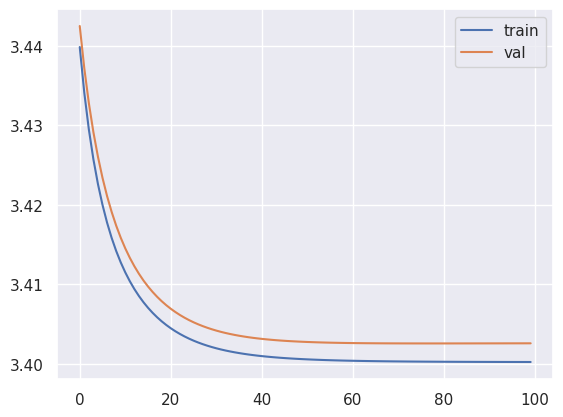

In [9]:
plt.plot(model.train_loss, label="train")
plt.plot(model.val_loss, label="val")
plt.legend()

plt.show()

In [10]:
pi_b_hats[bandit_data["action"]].shape

(5000,)

In [11]:
# LinUCB
noise_zero_ver=1.0
alpha=10

lin_ucb = LinUCB(
    n_action=n_action,
    dim_context=dim_context,
    noise_ver=noise_ver,
    noise_zero_ver=noise_zero_ver,
    alpha=alpha,
)

# LinTS
lin_ts = LinThompsonSampling(
    n_action=n_action,
    dim_context=dim_context,
    noise_ver=noise_ver,
    noise_zero_ver=noise_zero_ver,
)

# LogisticTS
n_epoch=5

logistic_ts = LogisticThompsonSampling(
    n_action=n_action,
    dim_context=dim_context,
    noise_ver=noise_ver,
    noise_zero_ver=noise_zero_ver,
    n_epoch=n_epoch,
)

policies = {"LinUCB": lin_ucb, "LinTS": lin_ts, "LogisticTS": logistic_ts}

In [13]:
# Inversed Propensity Score Estimator

pi_new_rewards = [] # [(policy_name, offline score, online score, ), ...]
for policy_name, policy in policies.items():
    
    # estimate reward
    ips = IPS(n_action=n_action, policy=policy)
    estimated_value = ips.estimate(
        contexts=bandit_data["context"], 
        pi_b_hats=pi_b_hats, 
        actions=bandit_data["action"], 
        rewards=bandit_data["reward"]
    )

    # ground truth
    simulator.run(policy=policy, web_server=web_server)
    online_score = simulator.observed_data["reward"].mean()
    
    pi_new_rewards.append(
        (policy_name, estimated_value, online_score)
    )

In [14]:
df = pd.DataFrame(pi_new_rewards, columns=['policy', 'offline_score', 'online_score'])

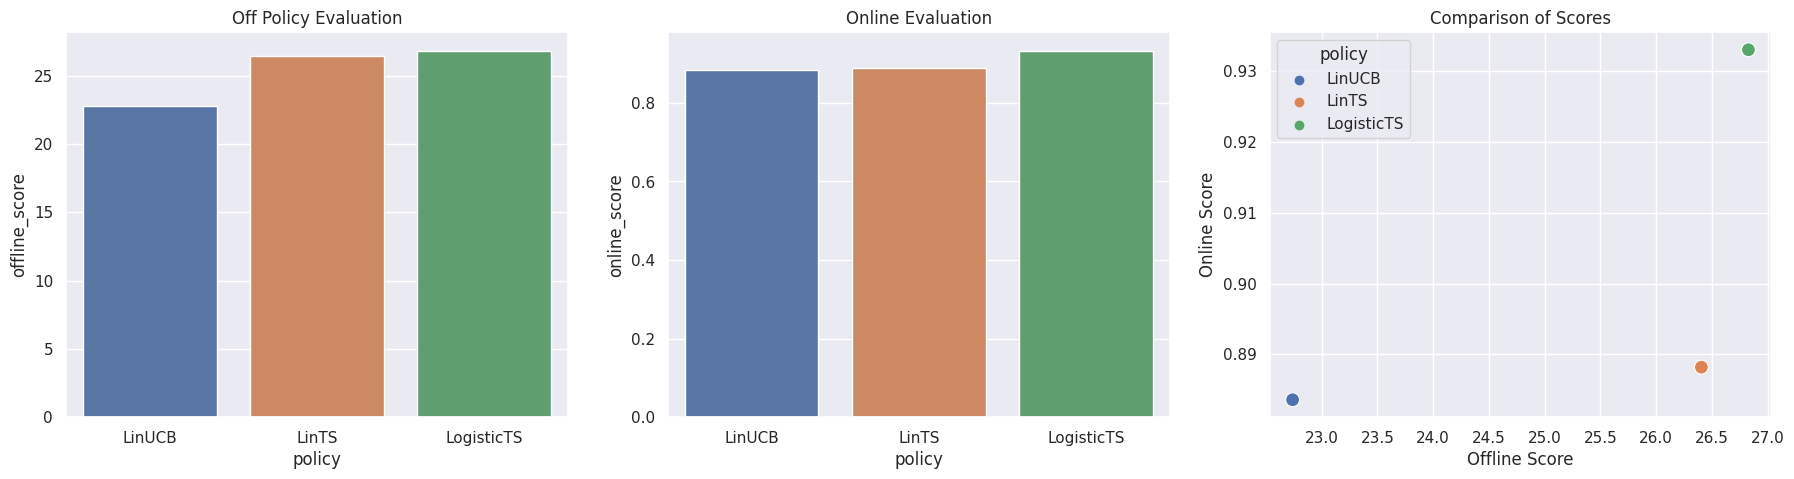

In [15]:
plt.figure(figsize=(22,5))

plt.subplot(1,3,1)
sns.barplot(x="policy", y='offline_score', data=df)
plt.title('Off Policy Evaluation')

plt.subplot(1,3,2)
sns.barplot(x="policy", y='online_score', data=df)
plt.title('Online Evaluation')

plt.subplot(1,3,3)
sns.scatterplot(x='offline_score', y='online_score', hue='policy', data=df, s=100)

plt.title('Comparison of Scores')
plt.xlabel('Offline Score')
plt.ylabel('Online Score')

plt.legend(title='policy')

plt.show()